# Offline alignment algorithms for tabular settings

In this lab, we will illustrate the theoretical properties of offline alignment algorithms with the help of tabular experimental settings. Offline alignment algorithms include variants such as

- DPO (https://arxiv.org/abs/2305.18290)
- IPO (https://arxiv.org/abs/2310.12036)
- GPO (https://arxiv.org/abs/2402.05749)

among other variants. On a high level, they take in a dataset of prompt and pairwise generations with preference annotation $(x, y_w, y_l)$ and minimize a preference loss
$$\min_\theta \mathbb{E}_{(x, y_w, y_l)}\mathbb{E}_{(x, y_w, y_l)}\left[ L(x, y_w, y_l) \right]$$

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def plot_stats(x, y, x_name="", y_name="", color="r"):
    plt.plot(x, y, color=color)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()

## Task 1: Tabular settings

To illustrate thoeretical properties of such algorithms, we focus on tabular settings. The name `tabular` largely stems from a reinforcement learning terminology.

More concretely, we will largely ignore the prompt $x$ and just focus on generations $y$. In tabular settings, we think of generations $y$ as categorical variables taking values from $1, 2, ... |Y|-1$ where $Y$ is the full space of all possible generations. All policies will be categorical distributions over $|Y|$ such values.

We start by simulating a dataset. We assume that there is a ground truth unknown reward $r$, and assume a behavior policy $\mu$. We randomly sample $N$ pairs $(y_1, y_2)$ i.i.d. from $\mu$ and assign their preference structure based on the Bradley-Terry model
$$y_1 \succ y_2 \ \ w.p.\ \  \sigma\left(r(y_1) - r(y_2)\right)$$
such that generations with higher rewards are more likely to be preferred.

YOUR TASK: implement key logic in generating the dataset.

In [3]:
def sigmoid(x):
    """Numerical stable implementation of sigmoid."""
    return 1.0 / (1.0 + np.exp(-x)) * (x > 0) + np.exp(x) / (1.0 + np.exp(x)) * (x <= 0)


# Total number of possible generations
Y = 10
all_possible_generations = list(range(Y))

# Create a ground truth reward model, unknown to downstream training
# The `augmenting_factor` is meant to make reward difference larger
augmenting_factor = 2.0
r = np.random.randn(Y) * augmenting_factor

# Create a behaivor policy
mu = np.random.rand(Y)
mu /= np.sum(mu)

# Number of sample pairs to create
N = 100

# Simulate
def generate_data(r, mu, N):
    """Generate pairwise samples from reward r and policy mu."""
    winning_generations = []
    losing_generations = []
    for _ in range(N):
        y1 = np.random.choice(all_possible_generations, p=mu)
        y2 = np.random.choice(all_possible_generations, p=mu)
        prob = sigmoid(r[y1] - r[y2])
        # TODO: make this a lab
        if np.random.rand() < prob:
            y_w = y1
            y_l = y2
        else:
            y_w = y2
            y_l = y1
        winning_generations.append(y_w)
        losing_generations.append(y_l)
    assert len(winning_generations) == N
    assert len(losing_generations) == N
    return winning_generations, losing_generations

winning_generations, losing_generations = generate_data(r, mu, N)

## Task 2: Fitting a Bradley-Terry reward model

Let's start by fitting a Bradley-Terry reward model to the dataset above. We would parameterize a reward model $r_\theta$, which in this case is just a vector with $|Y|$ numbers. Then we seek to minimize the loss function over generated dataset

$$\min_\theta -\mathbb{E}_{(y_1,y_2)}\left[\log \sigma\left(r_\theta(y_1) - r_\theta(y_2)\right)\right]$$

We will use Pytorch to calculate gradients automatically from a loss function. After minimizing the loss, we should expect $r_\theta$ to be close to the ground truth reward $r$, given a sufficiently big dataset.

YOUR TASK: implement the loss function. You might fine the utility function handy.

In [4]:
def index_reward(r, generations):
    """Index from reward vector using a set of generations.

    Args:
        r: torch.tensor of size |Y|
        generations: a list of integer generations
    Returns:
        A torch.tensor of indexed reward equivalent to [r[a] for a in generations]
    """
    generations_tensor = torch.tensor(generations, dtype=int)
    num_possible_generations = r.numel()
    oh_generations = torch.nn.functional.one_hot(
        generations_tensor, num_possible_generations
    )
    oh_generations = torch.tensor(oh_generations, dtype=float)
    return torch.matmul(oh_generations, r)

<ipython-input-4-9a4c5ac4de29>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  oh_generations = torch.tensor(oh_generations, dtype=float)


iteration 0 loss 0.7258785622137377
iteration 200 loss 0.45402296727363883
iteration 400 loss 0.4384346248394618
iteration 600 loss 0.4325065458777725
iteration 800 loss 0.4292767272337957
iteration 1000 loss 0.4272087188558894
iteration 1200 loss 0.4257560740515426
iteration 1400 loss 0.424672218619273
iteration 1600 loss 0.423828411587772
iteration 1800 loss 0.42315040194697495


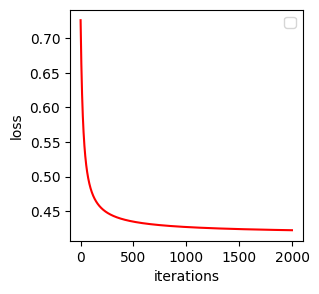

In [5]:
def loss_bradley_terry(r_theta, winning_generations, losing_generations):
    """Bradley-Terry loss.

    Args:
        r_theta: torch.tensor of size |Y|
        generations: a list of integer generations
    Returns:
        A torch.tensor that defines the loss.
    """
    r_win = index_reward(r_theta, winning_generations)
    r_lose = index_reward(r_theta, losing_generations)
    probs = torch.nn.functional.sigmoid(r_win - r_lose)
    return -torch.mean(torch.log(probs))


def get_loss_and_gradient(r_theta, winning_generations, losing_generations):
    """Get loss and gradient from the Bradley-Terry loss."""
    r_theta = torch.tensor(r_theta, dtype=float, requires_grad=True)
    loss = loss_bradley_terry(r_theta, winning_generations, losing_generations)
    loss.backward()
    return loss.detach().numpy(), r_theta.grad.numpy()


def optimize(r_theta_init, winning_generations, losing_generations, lr, num_optim_steps, print_loss = True, other_stats_fn = None):
    r_theta = np.copy(r_theta_init)
    losses = []
    other_stats = []
    for i in range(num_optim_steps):
        loss, grad = get_loss_and_gradient(r_theta, winning_generations, losing_generations)
        r_theta -= lr * grad
        if i % (num_optim_steps // 10) == 0 and print_loss:
            print(f"iteration {i} loss {loss}")
        losses.append(loss)
        if other_stats_fn is not None:
            other_stats.append(other_stats_fn(r, r_theta))
    return r_theta, losses, other_stats

# Parameters related to optimization
lr = 0.5
num_optim_steps = 2000

# Initialize a reward model
r_theta = np.random.rand(Y)

# Main loop for optimization
r_theta_optimized, losses, _ = optimize(
    r_theta, winning_generations, losing_generations, lr=lr, num_optim_steps=num_optim_steps
)

plt.figure(figsize=(3, 3))
plot_stats(np.arange(len(losses)), losses, x_name="iterations", y_name="loss", color="r")

## Task 2.1: Measuring the right distance

We should expect the loss to go down over iterations. Now, we can ablate the effect of generating more data $N$ and how close optimized $r_\theta$ is to the ground truth $r$. If we measure the L2 distance between the rewards, this does not seem to go down over time. Why does this happen?

YOUR TASK: implement a sensible metric that measures the right distance between $r$ and $r_\theta$ which should generally go down over time and converge to near zero.

<ipython-input-4-9a4c5ac4de29>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  oh_generations = torch.tensor(oh_generations, dtype=float)


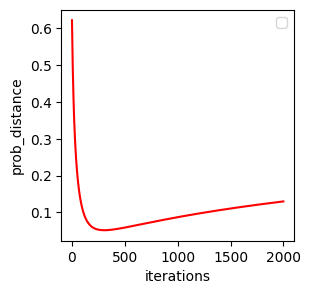

In [8]:
def l2_distance(x, y):
    return np.linalg.norm(x - y)


def softmax(r):
    """A numericall stable implementation of softmax."""
    r_max = np.max(r)
    scores = np.exp(r - r_max)
    return scores / np.sum(scores)


def kl_distance(r, r_theta):
    probs_r = softmax(r)
    probs_r_theta = softmax(r_theta)
    return np.sum(probs_r * np.log(probs_r / (probs_r_theta + 1e-8)))


# Main loop for optimization
r_theta_optimized, losses, metrics = optimize(
    r_theta, winning_generations, losing_generations, lr=lr, num_optim_steps=num_optim_steps, print_loss=False, other_stats_fn=kl_distance,
)

plt.figure(figsize=(3, 3))
plot_stats(np.arange(len(metrics)), metrics, x_name="iterations", y_name="prob_distance", color="r")

## Task 2.2: Investigate the impact of data size

Let us examine the impact of the dataset size parameterized by $N$ the number of pairwise generations.

YOUR TASK: Vary $N$ and see how that impacts the metrics. Ideally, we should expect the right metric to improve as we increase the number of samples consumed by the training algorithm.

In [12]:
all_Ns = [100, 10000, 10000]
metrics_all = []
for N in all_Ns:
    winning_generations, losing_generations = generate_data(r, mu, N)

    # Main loop for optimization
    r_theta_optimized, losses, metrics = optimize(
        r_theta, winning_generations, losing_generations, lr=lr, num_optim_steps=num_optim_steps, print_loss=False, other_stats_fn=prob_distance,
    )
    metrics_all.append(metrics)
    # print(N, l2_distance(r, r_theta_optimized), prob_distance(r, r_theta_optimized))

plt.figure(figsize=(3, 3))
colors = ['r', 'b', 'g']
for metrics, color in zip(metrics_all, colors):
    plot_stats(np.arange(len(metrics)), metrics, x_name="iterations", y_name="prob_distance", color=color)

NameError: name 'prob_distance' is not defined

In [11]:
plt.figure(figsize=(3, 3))
colors = ['r', 'b', 'g']
for metrics, color in zip(metrics_all, colors):
    plot_stats(np.arange(len(metrics)), metrics, x_name="iterations", y_name="prob_distance", color=color)

<Figure size 300x300 with 0 Axes>

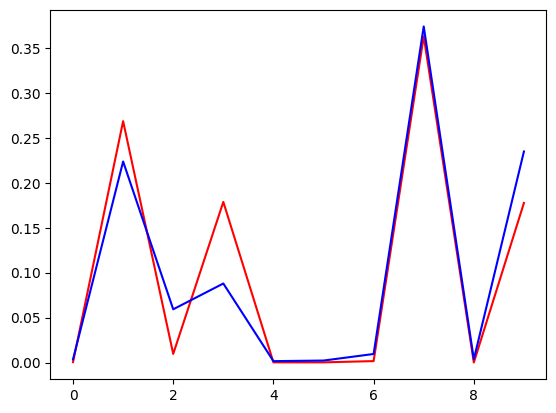

In [13]:
softmax(r_theta_optimized), softmax(r)
import matplotlib.pyplot as plt

plt.plot(softmax(r_theta_optimized), 'r')
plt.plot(softmax(r), 'b')

## Task 3: Direct preference optimization

Reinforcement learning from human feedback is built on the regularized policy optimization formulation. Given a reward $r$, the aim is to optimize the policy based on the KL regularized objective
$$\max_\theta \mathbb{E}_{y\sim \pi_\theta}[r(y)] - \beta \mathbb{KL}[\pi_\theta,\pi_\text{ref}]$$
where $\pi_\text{ref}$ is the reference policy, usually the starting point of the optimization. Solving the problem analytically, we have
$$\pi^\ast(y) \propto \pi_\text{ref}(y)\exp(\beta^{-1} r(y))$$

which hints at a close connection between the policy $\pi^\ast$ and the reward $r$. This means, any reward model loss can be cast into a policy learning loss. In fact, the direct preference optimization (DPO) loss is directly built on top of the Bradley-Terry loss we have investigated thus far. Concretely, we should implement the policy loss as

$$\min_\theta -\mathbb{E}_{(y_1,y_2)}\left[\log \sigma\left(\beta \log \frac{\pi_\theta(y_w)}{\pi_\text{ref}(y_w)} - \beta \log \frac{\pi_\theta(y_l)}{\pi_\text{ref}(y_l)}\right)\right]$$

Recall that $\pi_\theta$ and $\pi_\text{ref}$ here are both categorical distributions over $|Y|$ quantities.


YOUR TASK: implement a DPO loss, such that the policy performance generally improves over time. You might find it helpful to reuse ideas from previous sections.

<ipython-input-14-a1363261e747>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(logits)
<ipython-input-4-9a4c5ac4de29>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  oh_generations = torch.tensor(oh_generations, dtype=float)


iteration 0 loss 0.6931471805599452
iteration 200 loss 0.4696198850696969
iteration 400 loss 0.4603170034179149
iteration 600 loss 0.4565180738925851
iteration 800 loss 0.45436224949761056
iteration 1000 loss 0.4529497422526188
iteration 1200 loss 0.45194779532198803
iteration 1400 loss 0.4511992154081028
iteration 1600 loss 0.45061852698886135
iteration 1800 loss 0.45015492030623405


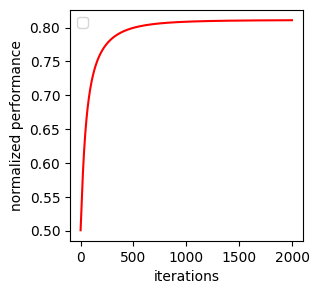

In [14]:
def loss_dpo(pi, pi_ref, beta, winning_generations, losing_generations):
    """DPO loss.

    Args:
        pi: torch.tensor of size |Y| indicating the learned policy
        pi_ref: torch.tensor of size |Y| indicating the reference policy
    Returns:
        A torch.tensor that defines the loss.
    """
    r = beta ** (-1) * torch.log(pi / pi_ref)
    return loss_bradley_terry(r, winning_generations, losing_generations)


def get_policy_from_logits(logits):
    # Softmax parameterization of polixy
    return torch.nn.functional.softmax(logits)


def get_performance_from_policy(r, pi):
    return (r.dot(pi) - np.min(r)) / (np.max(r) - np.min(r))


def get_performance_from_logits(r, logits):
    pi = softmax(logits)
    return get_performance_from_policy(r, pi)


def get_loss_and_gradient(logits, pi_ref, beta, winning_generations, losing_generations):
    """Get loss and gradient from the DPO loss."""
    logits = torch.tensor(logits, dtype=float, requires_grad=True)
    pi = get_policy_from_logits(logits)
    pi_ref = torch.tensor(pi_ref, dtype=float, requires_grad=False)
    loss = loss_dpo(pi, pi_ref, beta, winning_generations, losing_generations)
    loss.backward()
    return loss.detach().numpy(), logits.grad.numpy()


def optimize(logits_init, pi_ref, beta, r, winning_generations, losing_generations, lr, num_optim_steps, print_loss = True):
    logits = np.copy(logits_init)
    losses = []
    performance = []
    for i in range(num_optim_steps):
        loss, grad = get_loss_and_gradient(logits, pi_ref, beta, winning_generations, losing_generations)
        logits -= lr * grad
        if i % (num_optim_steps // 10) == 0 and print_loss:
            print(f"iteration {i} loss {loss}")
        losses.append(loss)
        performance.append(get_performance_from_logits(r, logits))
    return logits, losses, performance


# Total number of possible generations
Y = 10
all_possible_generations = list(range(Y))

# Create a ground truth reward model, unknown to downstream training
# The `augmenting_factor` is meant to make reward difference larger
augmenting_factor = 2.0
r = np.random.randn(Y) * augmenting_factor

# Create a behaivor policy
mu = np.random.rand(Y)
mu /= np.sum(mu)

# Create a reference policy
pi_ref = np.random.rand(Y)
pi_ref /= np.sum(pi_ref)

# Number of sample pairs to create
N = 100

# Simulate generations
winning_generations, losing_generations = generate_data(r, mu, N)

beta = 1.0
logits = np.log(pi_ref)
# Main loop for optimization
r_theta_optimized, losses, metrics = optimize(
    logits, pi_ref, beta, r, winning_generations, losing_generations, lr=lr, num_optim_steps=num_optim_steps, print_loss=True,
)

plt.figure(figsize=(3, 3))
plot_stats(np.arange(len(metrics)), metrics, x_name="iterations", y_name="normalized performance", color="r")

## Task 3.1: Investigate the impact of $\beta$


The optimization trades-off between reward maximization and regularization towards the reference policy. The hyper-parameter $\beta$ controls the trade-off.

YOUR TASK: Verify that the overall performance improvement decays as the regularization strength becomes stronger.

In [ ]:
beta = 1.0
logits = np.log(pi_ref)
# Main loop for optimization
r_theta_optimized, losses, metrics = optimize(
    logits, pi_ref, beta, r, winning_generations, losing_generations, lr=lr, num_optim_steps=num_optim_steps, print_loss=True,
)

plt.figure(figsize=(3, 3))
plot_stats(np.arange(len(metrics)), metrics, x_name="iterations", y_name="normalized performance", color="r")